Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Head:
   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0      119.992       157.302        74.997         0.00784           0.00007   
1      122.400       148.650       113.819         0.00968           0.00008   
2      116.682       131.111       111.555         0.01050           0.00009   
3      116.676       137.871       111.366         0.00997           0.00009   
4      116.014       141.781       110.655         0.01284           0.00011   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0   0.00370   0.00554     0.01109       0.04374             0.426  ...   
1   0.00465   0.00696     0.01394       0.06134             0.626  ...   
2   0.00544   0.00781     0.01633       0.05233             0.482  ...   
3   0.00502   0.00698     0.01505       0.05492             0.517  ...   
4   0.

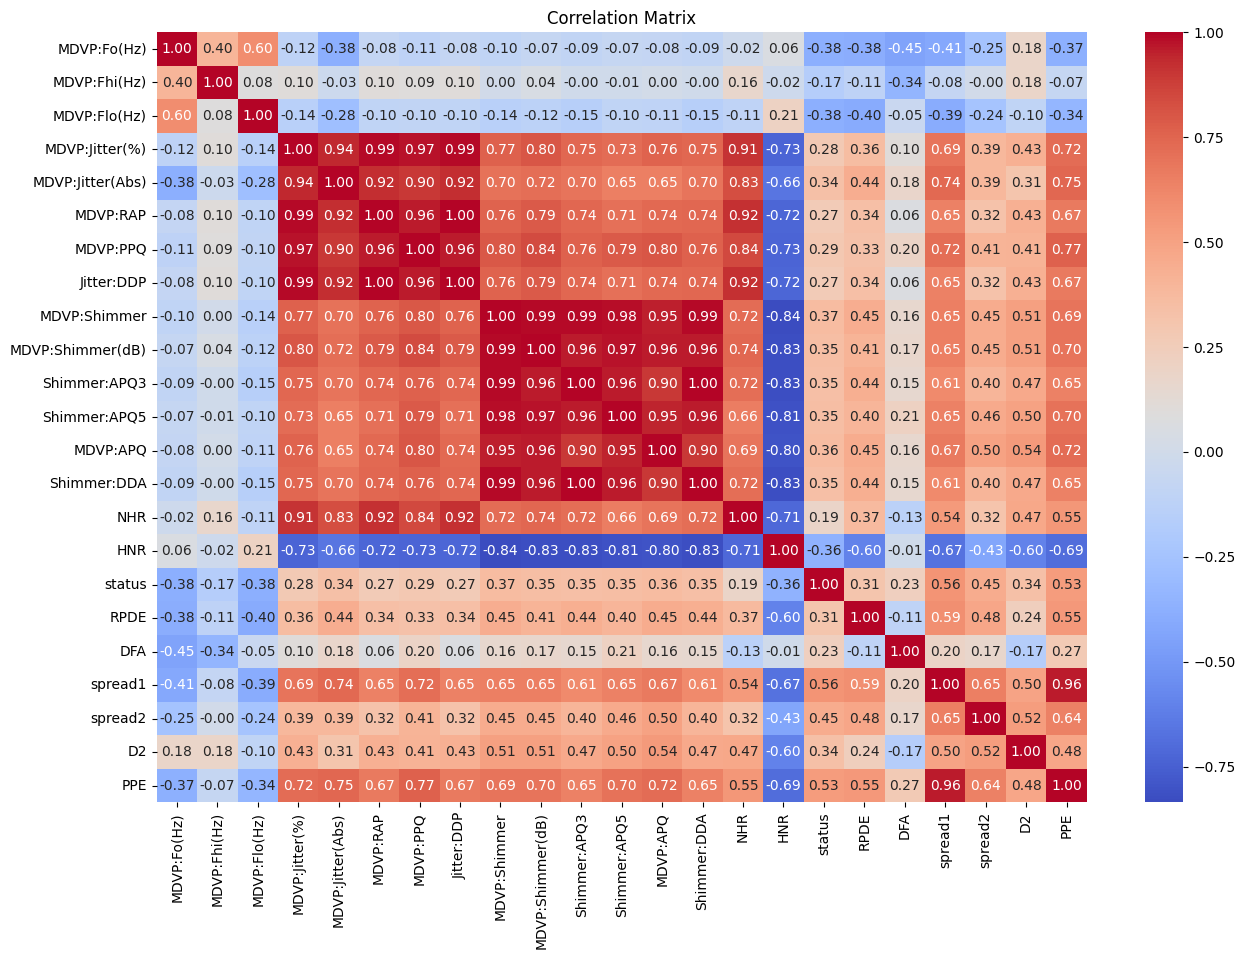

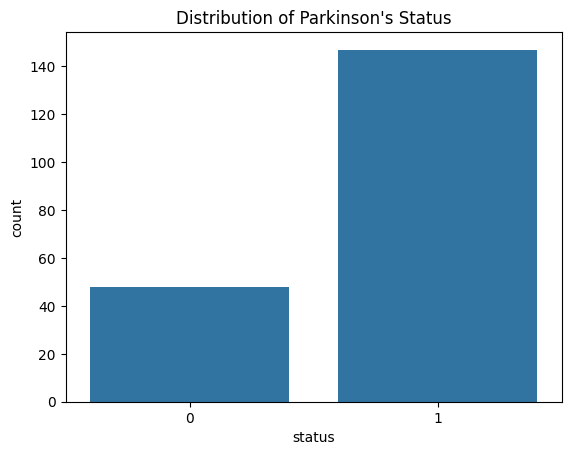

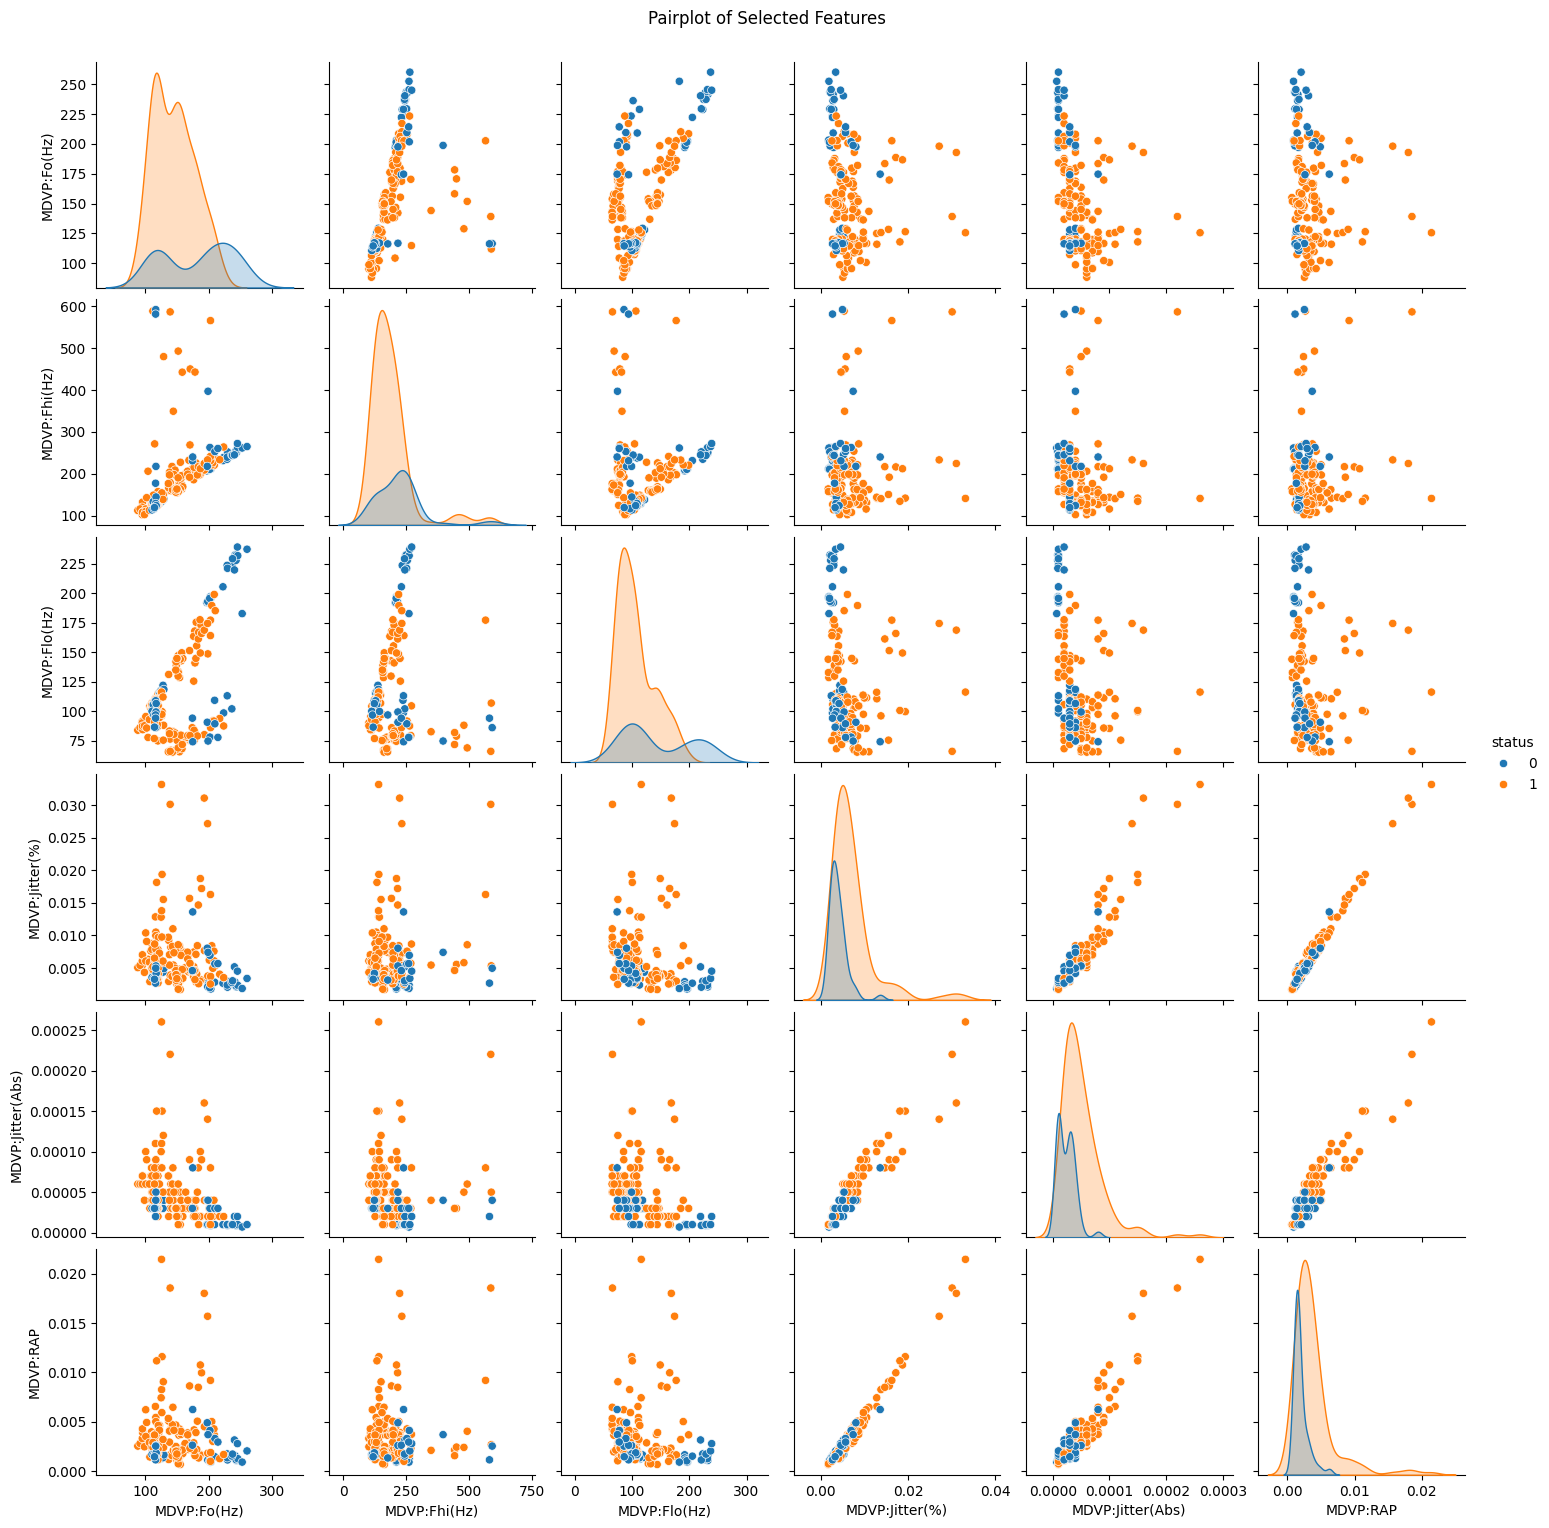

Baseline Accuracy (SVM): 0.8974
Baseline Accuracy (Random Forest): 0.9487


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Baseline Accuracy (XGBoost): 0.9487
Baseline Accuracy (Logistic Regression): 0.8974
Variance Threshold Accuracy (SVM): 0.8974
Variance Threshold Accuracy (Random Forest): 0.9487


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Variance Threshold Accuracy (XGBoost): 0.9487
Variance Threshold Accuracy (Logistic Regression): 0.8974
ANOVA Accuracy (SVM): 0.8974
ANOVA Accuracy (Random Forest): 0.9487
ANOVA Accuracy (XGBoost): 0.9231
ANOVA Accuracy (Logistic Regression): 0.8974
PCA Accuracy (SVM): 0.8974


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


PCA Accuracy (Random Forest): 0.8718
PCA Accuracy (XGBoost): 0.8462
PCA Accuracy (Logistic Regression): 0.8974
SVD Accuracy (SVM): 0.8974


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVD Accuracy (Random Forest): 0.8462
SVD Accuracy (XGBoost): 0.8462
SVD Accuracy (Logistic Regression): 0.8974
Drop Correlated Accuracy (SVM): 0.9231


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Drop Correlated Accuracy (Random Forest): 0.9487
Drop Correlated Accuracy (XGBoost): 0.9231
Drop Correlated Accuracy (Logistic Regression): 0.8974


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:26:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


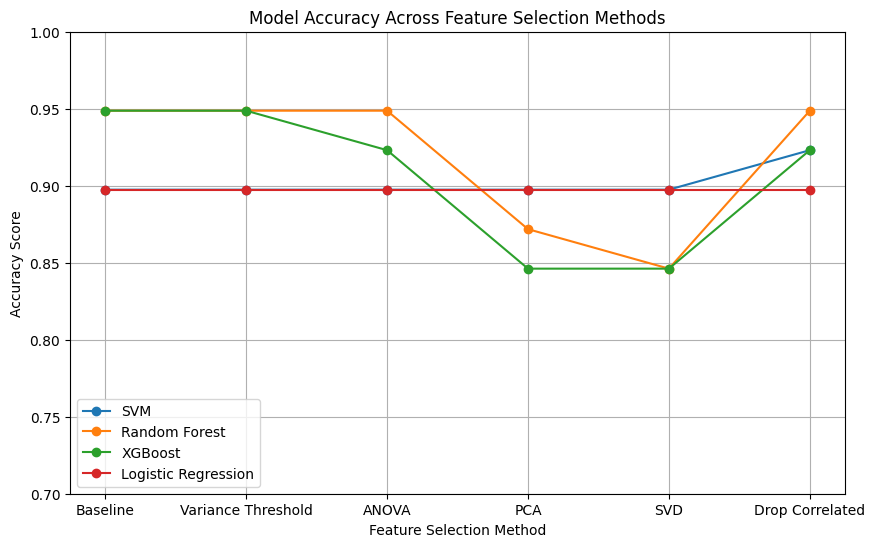

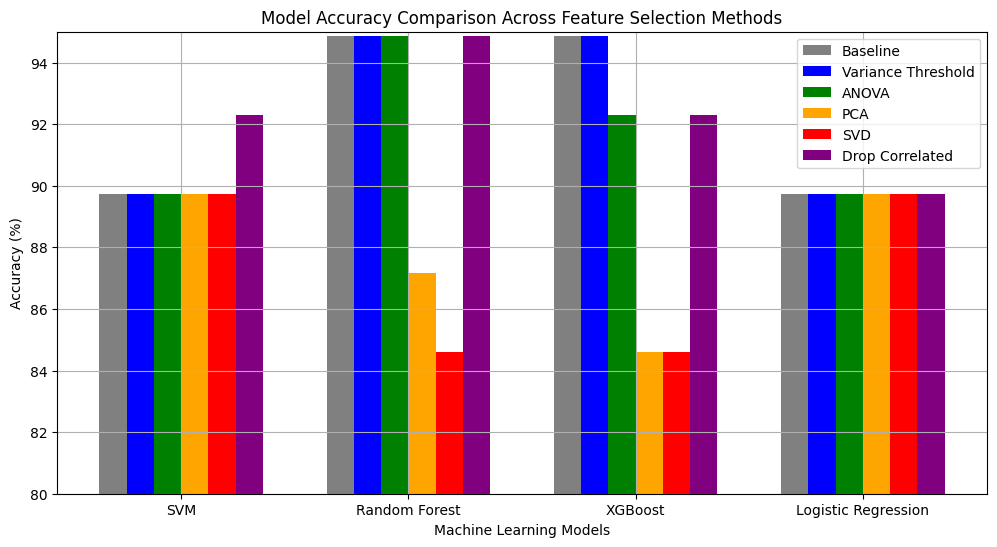


Best Performing Combination: Random Forest with Baseline Feature Selection
Best model saved successfully.


In [ ]:
# Parkinson's Disease Prediction - Final Version (With Full Feature Selection, EDA, and Model Comparison)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score
import joblib

# Mount Google Drive (Colab only)
from google.colab import drive
drive.mount('/content/drive')

# Load Dataset
file_path = Path('/content/drive/MyDrive/Datasets/parkinsons.data')
df = pd.read_csv(file_path)
df.drop(columns=['name'], inplace=True)

# ------------------ Exploratory Data Analysis (EDA) ------------------

# Display first few rows
print("Dataset Head:")
print(df.head())

# Summary statistics
print("\nDataset Description:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Distribution of target
sns.countplot(x='status', data=df)
plt.title("Distribution of Parkinson's Status")
plt.show()

# Pairplot of selected features
selected_cols = df.columns[:6].tolist() + ['status']
sns.pairplot(df[selected_cols], hue='status')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

# ------------------ Preprocessing ------------------

# Separate Features and Labels
X = df.drop(columns='status')
y = df['status']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------ Model Definitions ------------------

models = {
    "SVM": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(max_iter=500)
}

all_accuracies = {
    "Baseline": {},
    "Variance Threshold": {},
    "ANOVA": {},
    "PCA": {},
    "SVD": {},
    "Drop Correlated": {}
}

# ------------------ Evaluation Function ------------------

def evaluate_models(X_selected, method_name):
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    accuracies = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[name] = acc
        print(f"{method_name} Accuracy ({name}): {acc:.4f}")
    all_accuracies[method_name] = accuracies

# ------------------ Feature Selection & Evaluation ------------------

evaluate_models(X_scaled, "Baseline")

X_var_thresh = VarianceThreshold(threshold=0.01).fit_transform(X_scaled)
evaluate_models(X_var_thresh, "Variance Threshold")

X_anova = SelectKBest(score_func=f_classif, k=15).fit_transform(X_scaled, y)
evaluate_models(X_anova, "ANOVA")

X_pca = PCA(n_components=0.95).fit_transform(X_scaled)
evaluate_models(X_pca, "PCA")

X_svd = TruncatedSVD(n_components=10).fit_transform(X_scaled)
evaluate_models(X_svd, "SVD")

# ------------------ Drop Highly Correlated Features ------------------
cor_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr().abs()
upper = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_uncorr = pd.DataFrame(X_scaled, columns=X.columns).drop(columns=to_drop)
evaluate_models(X_uncorr, "Drop Correlated")

# ------------------ Line Plot: Accuracy Comparison ------------------

methods = list(all_accuracies.keys())
model_names = list(models.keys())

plt.figure(figsize=(10, 6))
for model_name in model_names:
    accuracies = [all_accuracies[method][model_name] for method in methods]
    plt.plot(methods, accuracies, marker='o', label=model_name)

plt.xlabel("Feature Selection Method")
plt.ylabel("Accuracy Score")
plt.title("Model Accuracy Across Feature Selection Methods")
plt.legend()
plt.ylim(0.7, 1.0)
plt.grid()
plt.show()

# ------------------ Bar Plot: Accuracy Comparison ------------------

baseline = [all_accuracies["Baseline"][m]*100 for m in model_names]
variance_threshold = [all_accuracies["Variance Threshold"][m]*100 for m in model_names]
anova = [all_accuracies["ANOVA"][m]*100 for m in model_names]
pca = [all_accuracies["PCA"][m]*100 for m in model_names]
svd = [all_accuracies["SVD"][m]*100 for m in model_names]
drop_corr = [all_accuracies["Drop Correlated"][m]*100 for m in model_names]

x = np.arange(len(model_names))
width = 0.12

plt.figure(figsize=(12, 6))
plt.bar(x - 2.5*width, baseline, width, label="Baseline", color="gray")
plt.bar(x - 1.5*width, variance_threshold, width, label="Variance Threshold", color="blue")
plt.bar(x - 0.5*width, anova, width, label="ANOVA", color="green")
plt.bar(x + 0.5*width, pca, width, label="PCA", color="orange")
plt.bar(x + 1.5*width, svd, width, label="SVD", color="red")
plt.bar(x + 2.5*width, drop_corr, width, label="Drop Correlated", color="purple")

plt.xlabel("Machine Learning Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison Across Feature Selection Methods")
plt.xticks(x, model_names)
plt.legend()
plt.ylim(80, 95)
plt.grid()
plt.show()

# ------------------ Save Best Performing Model ------------------

best_method = max(all_accuracies, key=lambda method: max(all_accuracies[method].values()))
best_model_name = max(all_accuracies[best_method], key=all_accuracies[best_method].get)

print(f"\nBest Performing Combination: {best_model_name} with {best_method} Feature Selection")

if best_method == "Baseline":
    X_best = X_scaled
elif best_method == "Variance Threshold":
    X_best = X_var_thresh
elif best_method == "ANOVA":
    X_best = X_anova
elif best_method == "PCA":
    X_best = X_pca
elif best_method == "SVD":
    X_best = X_svd
elif best_method == "Drop Correlated":
    X_best = X_uncorr

final_model = models[best_model_name]
final_model.fit(X_best, y)
joblib.dump(final_model, f"best_model_{best_model_name}_{best_method}.pkl")
print("Best model saved successfully.")
